In [1]:
import re
import torch
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from gliner import GLiNER

LABELS = ['information temporelle', 'producteur/artisan', 'organisation',
          'point de vente', 'réseau de magasins', 'nombre de magasins',
          'nombre de producteurs', 'lieu', 'produit', 'magasin de producteurs', 'déclencheur']
LABEL_TO_ID = {l: i for i, l in enumerate(LABELS)}
ID_TO_LABEL = {i: l for l, i in LABEL_TO_ID.items()}
O_LABEL_ID = -1  # Label "O" pour les spans non-entités

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
gliner = GLiNER.from_pretrained("best-gliner_model-v1", load_tokenizer=True).to(device)
nuner = GLiNER.from_pretrained("best-nuner_model-v1", load_tokenizer=True).to(device)

/home/pape/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-04 23:32:15.081486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762299135.142414  569230 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762299135.213015  569230 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762299135.363309  569230 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:0

In [2]:
import json
from needed_functions import *
from typing import List, Dict, Any

with open('239_annotated_data.json', 'r', encoding='utf-8') as f:
    train_data_base = json.load(f)

filtered_data = filter_and_lowercase_entity_types(remove_text_duplicates(train_data_base), ["Autres"])

In [3]:
len(filtered_data)

237

In [4]:
from annotation_agreement import *
import pandas as pd

df = pd.read_csv("Corpus_Preprocessed.csv")
df = df.rename(columns={"Unnamed: 0": "ID"})
articles = df["Article"]
len(articles)

import pandas as pd
import json
from typing import List, Dict

def remove_articles_from_filtered_data(articles: pd.Series, filtered_data: List[Dict]) -> pd.Series:

    annotated_texts = set(d['data']['text'].strip() for d in filtered_data)
    cleaned_articles = articles[~articles.str.strip().isin(annotated_texts)].reset_index(drop=True)

    print(f"🧹 {len(articles) - len(cleaned_articles)} articles supprimés car déjà annotés.")
    return cleaned_articles

articles_cleaned = remove_articles_from_filtered_data(articles, filtered_data)
len(articles_cleaned)

[nltk_data] Downloading package punkt to /home/pape/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🧹 208 articles supprimés car déjà annotés.


9967

In [5]:
label_studio , agreement, disagreement = extract_agreed_entities_labelstudio(
    articles = articles_cleaned,
    gliner = gliner,
    nuner = nuner,
    tokenizer = tokenizer,
    labels = LABELS,
    max_articles = len(articles_cleaned),
    max_tokens = 400,
    overlap_tokens = 50
) 

print(f"Nombre d'accords : {agreement}")
print(f"Nombre de désaccords : {disagreement}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1823 > 512). Running this sequence through the model will result in indexing errors
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/pape/.local/lib/python3.10/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 1024 has been truncated to 512
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
/home/pape/.local/lib/python3.10/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 1070 has been truncated to 512
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
/home/pape/.local/lib/python3.10/site-packages/gliner/data_proc

Nombre d'accords : 251330
Nombre de désaccords : 156913


In [10]:
def convert_predictions_to_annotations(label_studio_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Convertit 'predictions' en 'annotations' dans les données Label Studio."""
    converted_data = []
    
    for item in label_studio_data:
        new_item = item.copy()
        
        if 'predictions' in item:
            new_item['annotations'] = item['predictions']
            del new_item['predictions']
        
        converted_data.append(new_item)
    
    return converted_data

def replace_label(label_studio_data, old_label, new_label):
    """
    Remplace un label par un autre dans les données Label Studio.
    """
    for item in label_studio_data:
        if 'annotations' in item:
            for prediction in item['annotations']:
                for result in prediction['result']:
                    if result['type'] == 'labels':
                        labels = result['value']['labels']
                        for i, label in enumerate(labels):
                            if label == old_label:
                                labels[i] = new_label
    return label_studio_data

In [11]:
label_studio_data = convert_predictions_to_annotations(label_studio)
for_train = replace_label(label_studio_data, 'information temporelle', 'temporelle')

📊 Statistiques d'annotations :
Nombre total d'entités annotées : 251330
Répartition par label :
- organisation : 21459
- lieu : 65825
- produit : 54786
- magasin de producteurs : 11214
- producteur/artisan : 32969
- temporelle : 34949
- déclencheur : 10627
- nombre de producteurs : 5845
- nombre de magasins : 1403
- point de vente : 11393
- réseau de magasins : 860


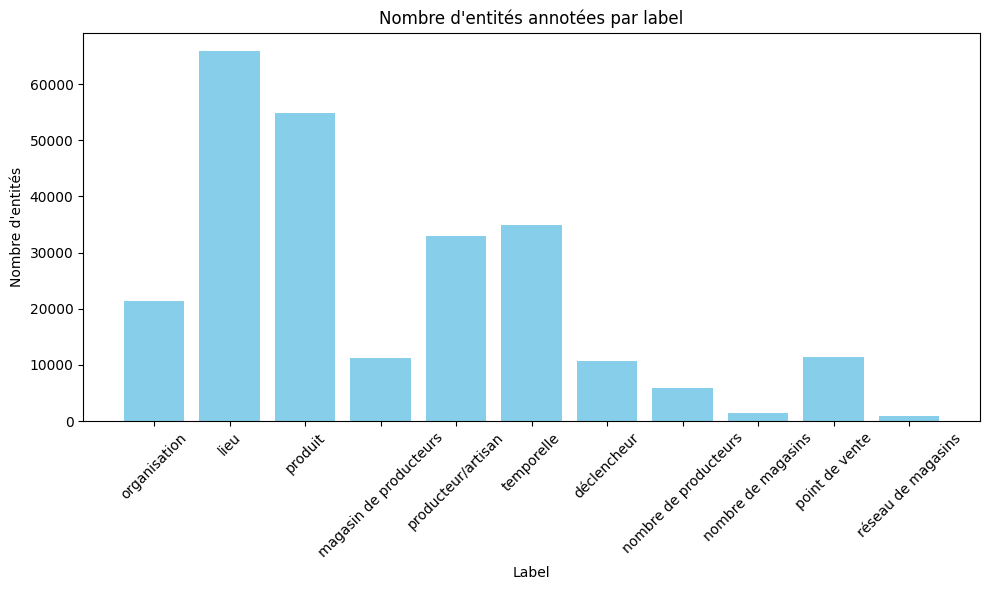

In [13]:
analyze_labelstudio_annotations(for_train)

In [ ]:
# labelstudio_data , total_entities = extract_entities_labelstudio(
#     articles = articles_cleaned,
#     model = nuner,
#     tokenizer = tokenizer,
#     labels = LABELS,
#     max_articles = len(articles_cleaned),
#     max_tokens = 400,
#     overlap_tokens = 50
# ) 

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/pape/.local/lib/python3.10/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 1024 has been truncated to 512
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
/home/pape/.local/lib/python3.10/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 1070 has been truncated to 512
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
/home/pape/.local/lib/python3.10/site-packages/gliner/data_processing/processor.py:296: UserWarning: Sentence of length 531 has been truncated to 512
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


In [ ]:
# total_entities, len(labelstudio_data) 

(232496, 7180)

In [ ]:
# import json
# import os

# # Enregistrer dans le répertoire actuel
# output_path = os.path.join(os.getcwd(), "nuner_annotations.json")

# with open(output_path, 'w', encoding='utf-8') as f:
#     json.dump(labelstudio_data, f, ensure_ascii=False, indent=2)

# print(f"✓ Données sauvegardées dans: {output_path}")

✓ Données sauvegardées dans: /home/pape/myenv/nuner_annotations.json


In [ ]:
# gliner (237534, 7183)